In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
        
    closeDataSet = closeDataSet.loc[weightDf.iloc[0].name:] # 데이터셋 일자를 weightDf에 맞춘다.
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    # 평모스 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n
    
    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)
    
    # 투자비중, 평모스 리턴
    return weight, avgMomentumScore

### 모멘텀 계산 방법

In [6]:
# 데이터 로드
kodex200 = getCloseData("069500", "2002", "2022-7-31")
kodex200

Date
2002-10-14     5400
2002-10-15     5533
2002-10-16     5557
2002-10-17     5634
2002-10-18     5873
              ...  
2022-07-25    31910
2022-07-26    32025
2022-07-27    32035
2022-07-28    32245
2022-07-29    32385
Name: Close, Length: 4897, dtype: int64

In [7]:
# 리밸런싱 일자
rebalDate = getRebalancingDate(kodex200)
rebalDate

DatetimeIndex(['2002-10-31', '2002-11-29', '2002-12-30', '2003-01-30',
               '2003-02-28', '2003-03-31', '2003-04-30', '2003-05-30',
               '2003-06-30', '2003-07-31',
               ...
               '2021-10-29', '2021-11-30', '2021-12-30', '2022-01-28',
               '2022-02-28', '2022-03-31', '2022-04-29', '2022-05-31',
               '2022-06-30', '2022-07-29'],
              dtype='datetime64[ns]', name='Date', length=238, freq=None)

In [8]:
# 리밸런싱 일자 종가 데이터
priceOnRebalDate =  kodex200.loc[rebalDate]
priceOnRebalDate

Date
2002-10-31     5754
2002-11-29     6414
2002-12-30     5676
2003-01-30     5289
2003-02-28     5186
              ...  
2022-03-31    36472
2022-04-29    35433
2022-05-31    35363
2022-06-30    30808
2022-07-29    32385
Name: Close, Length: 238, dtype: int64

**n개월 모멘텀 = 현재 가격 / n개월 전 가격**  

In [9]:
# n개월 모멘텀 구하기
# n개월 모멘텀 = 현재 가격 / n개월 전 가격
# n개월 수익률과 같은 개념
n = 1
momentum = (priceOnRebalDate / priceOnRebalDate.shift(n)).fillna(0)
momentum

Date
2002-10-31    0.000000
2002-11-29    1.114703
2002-12-30    0.884939
2003-01-30    0.931818
2003-02-28    0.980526
                ...   
2022-03-31    1.012970
2022-04-29    0.971512
2022-05-31    0.998024
2022-06-30    0.871193
2022-07-29    1.051188
Name: Close, Length: 238, dtype: float64

**n개월 모멘텀 스코어: if n개월 모멘텀 > 1, 1, 0**  


In [10]:
# n개월 모멘텀 스코어
# n개월 모멘텀 스코어: if n개월 모멘텀 > 1, 1, 0
n = 1
momentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(n) > 1, 1, 0)
momentumScore

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

**n개월 평균 모멘텀 스코어: 1~n개월 모멘텀 스코어의 평균**

In [11]:
n = 12
avgMomentumScore = 0
for i in range(1, n+1):
    avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore

avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index)
avgMomentumScore = avgMomentumScore / n
avgMomentumScore

,0
Date,
2002-10-31,0.000000
2002-11-29,0.083333
2002-12-30,0.000000
2003-01-30,0.000000
2003-02-28,0.000000
...,...
2022-03-31,0.166667
2022-04-29,0.000000
2022-05-31,0.000000


### 평균모멘텀 스코어에 따른 투자 비중 계산

In [13]:
# 데이터 로드
kodex200 = getCloseData("069500", "2000", "2022-7-30") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2000", "2022-7-30") # kodex 국고채 10년물 etf

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True)
closeDataSet

,kodex200,kodex10Bond
Date,,
2012-01-20,21744,49960.0
2012-01-25,21820,49960.0
2012-01-26,21841,49930.0
2012-01-27,21875,50000.0
2012-01-30,21628,50130.0
...,...,...
2022-07-25,31910,64485.0
2022-07-26,32025,64640.0
2022-07-27,32035,64900.0


In [14]:
# 리밸런싱 일자
rebalDate = getRebalancingDate(closeDataSet)
# 리밸런싱 일자 종가 데이터
priceOnRebalDate =  closeDataSet.loc[rebalDate]

In [15]:
# 12개월 평균모멘텀스코어 계산
n = 12
avgMomentumScore = 0
for i in range(1, n+1):
    avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns)
avgMomentumScore = avgMomentumScore / n
avgMomentumScore

,kodex200,kodex10Bond
Date,,
2012-01-31,0.000000,0.000000
2012-02-29,0.083333,0.000000
2012-03-30,0.083333,0.000000
2012-04-30,0.083333,0.250000
2012-05-31,0.000000,0.333333
...,...,...
2022-03-31,0.166667,0.000000
2022-04-29,0.000000,0.000000
2022-05-31,0.000000,0.000000


In [16]:
# 평균 모멘텀 스코어에 따른 투자 비중 계산
avgMomentumScore.sum(axis=1)

Date
2012-01-31    0.000000
2012-02-29    0.083333
2012-03-30    0.083333
2012-04-30    0.333333
2012-05-31    0.333333
                ...   
2022-03-31    0.166667
2022-04-29    0.000000
2022-05-31    0.000000
2022-06-30    0.000000
2022-07-29    0.333333
Length: 127, dtype: float64

In [17]:
weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
weight

,kodex200,kodex10Bond
Date,,
2012-01-31,0.00,0.00
2012-02-29,1.00,0.00
2012-03-30,1.00,0.00
2012-04-30,0.25,0.75
2012-05-31,0.00,1.00
...,...,...
2022-03-31,1.00,0.00
2022-04-29,0.00,0.00
2022-05-31,0.00,0.00


In [18]:
# 주식, 채권의 비중이 모두 0인 구간에는 현금으로 보유합니다.
weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)
weight

,kodex200,kodex10Bond,cash
Date,,,
2012-01-31,0.00,0.00,1
2012-02-29,1.00,0.00,0
2012-03-30,1.00,0.00,0
2012-04-30,0.25,0.75,0
2012-05-31,0.00,1.00,0
...,...,...,...
2022-03-31,1.00,0.00,0
2022-04-29,0.00,0.00,1
2022-05-31,0.00,0.00,1


### 함수화

In [19]:
def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    # 평모스 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n
    
    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)
    
    # 투자비중, 평모스 리턴
    return weight, avgMomentumScore

In [20]:
closeDataSet

,kodex200,kodex10Bond
Date,,
2012-01-20,21744,49960.0
2012-01-25,21820,49960.0
2012-01-26,21841,49930.0
2012-01-27,21875,50000.0
2012-01-30,21628,50130.0
...,...,...
2022-07-25,31910,64485.0
2022-07-26,32025,64640.0
2022-07-27,32035,64900.0


In [21]:
weight6, avgMomentumScore6 = getWeightByAvgMomentumScore(closeDataSet, n=6)
weight12, avgMomentumScore12 = getWeightByAvgMomentumScore(closeDataSet, n=12)

In [18]:
pd.set_option('display.max_rows', None)

In [22]:
weight6

,kodex200,kodex10Bond,cash
Date,,,
2012-01-31,0.00,0.00,1
2012-02-29,1.00,0.00,0
2012-03-30,1.00,0.00,0
2012-04-30,0.25,0.75,0
2012-05-31,0.00,1.00,0
...,...,...,...
2022-03-31,1.00,0.00,0
2022-04-29,0.00,0.00,1
2022-05-31,0.00,0.00,1


In [23]:
weight12

,kodex200,kodex10Bond,cash
Date,,,
2012-01-31,0.00,0.00,1
2012-02-29,1.00,0.00,0
2012-03-30,1.00,0.00,0
2012-04-30,0.25,0.75,0
2012-05-31,0.00,1.00,0
...,...,...,...
2022-03-31,1.00,0.00,0
2022-04-29,0.00,0.00,1
2022-05-31,0.00,0.00,1


### 백테스트

#### **투자 비중이 0인 구간에는 현금을 보유. 따라서, closeDataSet에도 현금을 추가**

- 현금의 가격은 1로 간주합니다.
- 단기 예적금 등으로 1~2% 연 수익률을 얻을 수는 있지만,
- 보수적인 관점에서 백테스트하기 위함입니다.

In [24]:
closeDataSet

,kodex200,kodex10Bond
Date,,
2012-01-20,21744,49960.0
2012-01-25,21820,49960.0
2012-01-26,21841,49930.0
2012-01-27,21875,50000.0
2012-01-30,21628,50130.0
...,...,...
2022-07-25,31910,64485.0
2022-07-26,32025,64640.0
2022-07-27,32035,64900.0


In [25]:
closeDataSet['cash'] = 1
closeDataSet

,kodex200,kodex10Bond,cash
Date,,,
2012-01-20,21744,49960.0,1
2012-01-25,21820,49960.0,1
2012-01-26,21841,49930.0,1
2012-01-27,21875,50000.0,1
2012-01-30,21628,50130.0,1
...,...,...,...
2022-07-25,31910,64485.0,1
2022-07-26,32025,64640.0,1
2022-07-27,32035,64900.0,1


**12개월 평균 모멘텀 스코어 투자 비중을 이용한 백테스트**

In [26]:
_, momentum12CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight12)

print(f"12개월 평모스 최종수익률: {momentum12CumReturn.iloc[-1]}")
cagr12, dd12, mdd12 = getEvaluation(momentum12CumReturn)

12개월 평모스 최종수익률: 1.6674569556507637
최종 수익률: 1.6674569556507637
cagr: 1.051087168711134
mdd: 19.468388069150823


**6개월 평균 모멘텀 스코어 투자 비중을 이용한 백테스트**

In [27]:
_, momentum6CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight6)

print(f"6개월 평모스 최종수익률: {momentum6CumReturn.iloc[-1]}")
cagr6, dd6, mdd6 = getEvaluation(momentum6CumReturn)

6개월 평모스 최종수익률: 1.7934762865509029
최종 수익률: 1.7934762865509029
cagr: 1.05857609104575
mdd: 15.900267540168104


**시장수익률 계산 (코스피200)**

In [28]:
rebalDate = getRebalancingDate(closeDataSet)

In [29]:
stockCumReturn = getCumulativeReturn(kodex200.loc[rebalDate[0]:])

print(f"시장 최종수익률: {stockCumReturn.iloc[-1]}")
stockCagr, stockDD, stockMDD = getEvaluation(stockCumReturn)

시장 최종수익률: 1.4893763796909492
최종 수익률: 1.4893763796909492
cagr: 1.0395823644525526
mdd: 38.0848925062421


**시각화 비교**

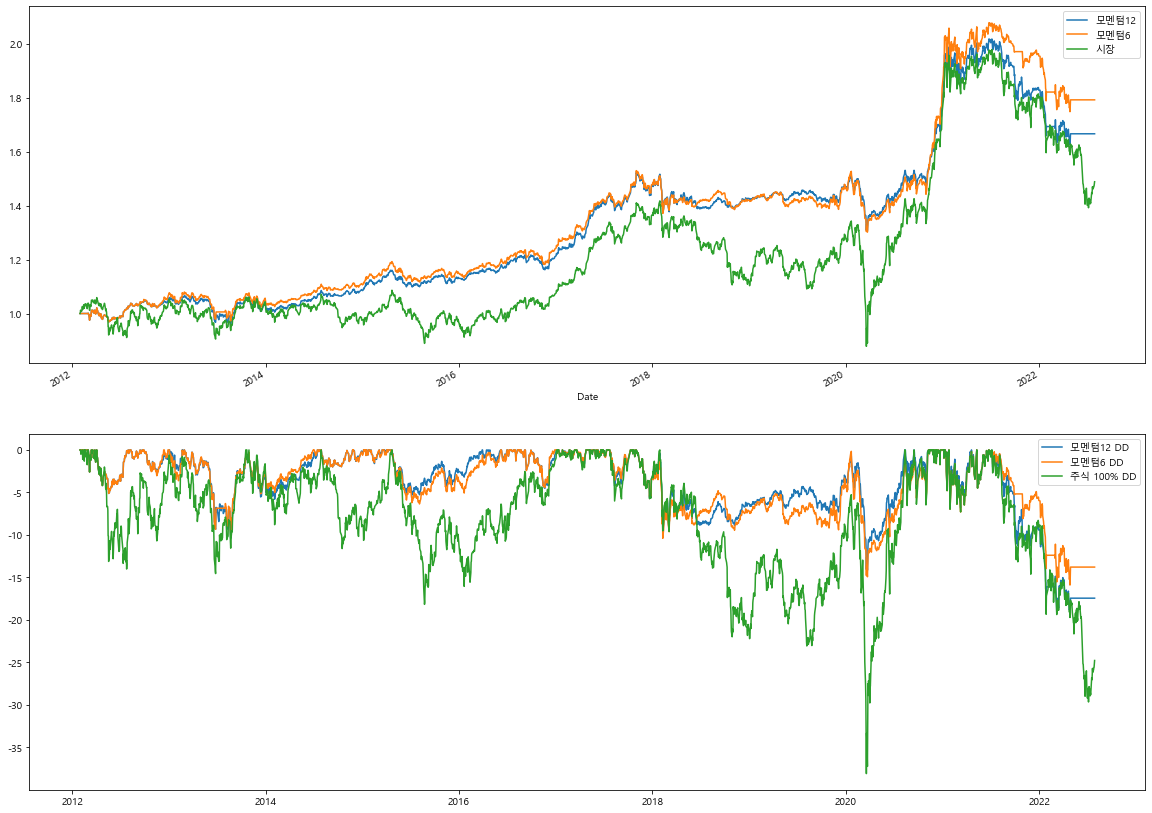

In [30]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
momentum12CumReturn.plot(label="모멘텀12")
momentum6CumReturn.plot(label="모멘텀6")
stockCumReturn.plot(label="시장")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(-dd12, label="모멘텀12 DD")
plt.plot(-dd6, label="모멘텀6 DD")
plt.plot(-stockDD, label="주식 100% DD")
plt.legend()

plt.show()

### 직접 해볼만한 이슈

* 10년물 채권에서 20년물 채권으로 바꿔서 백테스트를 해본다면?  
(장기채권은 단기채권에 비해 변동성이 높습니다.)  
  
* 미국 자산으로 평균 모멘텀 스코어 전략을 백테스트 해본다면?